In [1]:

import numpy as np
import torch
import PIL.Image as Image
import sys
sys.path.append('/Data3/cao/ZiHanCao/exps/panformer')

from model.lfq_vae.quantizer import LFQ, LFQ_v0
from model.lfq_vae.autoencoder import Encoder, Decoder

torch.cuda.set_device(0)
# weight_d = torch.load('/Data3/cao/ZiHanCao/exps/panformer/log_file/lfq_vae/unify_image_fusion_vae/2024-11-17-16-36-44_lfq_vae_loop_up_free_quantization_vae/weights/ema_model.pth', weights_only=True)
weight_d = torch.load('/Data3/cao/ZiHanCao/exps/panformer/model/lfq_vae/ckpts/imagenet_256_L.ckpt', weights_only=True)['state_dict']

enc_d = {}
dec_d = {}
for k, v in weight_d.items():
    if k.startswith('encoder'):
        enc_d[k.replace('encoder.', '')] = v
    elif k.startswith('decoder'):
        dec_d[k.replace('decoder.', '')] = v
print(enc_d.keys())
print(dec_d.keys())

# enc_d = weight_d['ema_encoder']['ema_model']
# dec_d = weight_d['ema_decoder']['ema_model']

# lfq = LFQ(dim=18, channel_first=True).cuda()
lfq = LFQ_v0(dim=18, codebook_size=2**18).cuda()

encoder = Encoder(ch=128, z_channels=18, in_channels=3, ch_mult=(1, 1, 2, 2, 4), resolution=128, num_res_blocks=4).cuda()
decoder = Decoder(ch=128, out_ch=3, z_channels=18, in_channels=3, ch_mult=(1, 1, 2, 2, 4), resolution=128, num_res_blocks=4).cuda()

encoder.load_state_dict(enc_d)
decoder.load_state_dict(dec_d)
print('encoder and decoder loaded')

encoder.half()
decoder.half()

encoder.eval()
decoder.eval()
lfq.eval()

del enc_d, dec_d, weight_d
torch.cuda.empty_cache()



set torch.backends.opt_einsum.strategy to `auto-hq`
[2024-12-02 01:53:24,252] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


INFO:root:gcc -pthread -B /home/office-401/.conda/envs/zihan2/compiler_compat -fno-strict-overflow -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/office-401/.conda/envs/zihan2/include -fPIC -O2 -isystem /home/office-401/.conda/envs/zihan2/include -fPIC -c /tmp/tmp1py4yx2c/test.c -o /tmp/tmp1py4yx2c/test.o
INFO:root:gcc -pthread -B /home/office-401/.conda/envs/zihan2/compiler_compat /tmp/tmp1py4yx2c/test.o -laio -o /tmp/tmp1py4yx2c/a.out
INFO:root:gcc -pthread -B /home/office-401/.conda/envs/zihan2/compiler_compat -fno-strict-overflow -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/office-401/.conda/envs/zihan2/include -fPIC -O2 -isystem /home/office-401/.conda/envs/zihan2/include -fPIC -c /tmp/tmpu9qnd00g/test.c -o /tmp/tmpu9qnd00g/test.o
INFO:root:gcc -pthread -B /home/office-401/.conda/envs/zihan2/compiler_compat /tmp/tmpu9qnd00g/test.o -L/usr/local/cuda -L/usr/local/cuda/lib64 -lcufile -o /tmp/tmpu9qnd00g/a.out
/home/office-401/.conda/envs/zihan2/compiler_compat/ld: warning: libstdc++.so.6

trying to import PatchMergeModule
dict_keys(['conv_in.weight', 'down.0.block.0.norm1.weight', 'down.0.block.0.norm1.bias', 'down.0.block.0.norm2.weight', 'down.0.block.0.norm2.bias', 'down.0.block.0.conv1.weight', 'down.0.block.0.conv2.weight', 'down.0.block.1.norm1.weight', 'down.0.block.1.norm1.bias', 'down.0.block.1.norm2.weight', 'down.0.block.1.norm2.bias', 'down.0.block.1.conv1.weight', 'down.0.block.1.conv2.weight', 'down.0.block.2.norm1.weight', 'down.0.block.2.norm1.bias', 'down.0.block.2.norm2.weight', 'down.0.block.2.norm2.bias', 'down.0.block.2.conv1.weight', 'down.0.block.2.conv2.weight', 'down.0.block.3.norm1.weight', 'down.0.block.3.norm1.bias', 'down.0.block.3.norm2.weight', 'down.0.block.3.norm2.bias', 'down.0.block.3.conv1.weight', 'down.0.block.3.conv2.weight', 'down.0.downsample.weight', 'down.0.downsample.bias', 'down.1.block.0.norm1.weight', 'down.1.block.0.norm1.bias', 'down.1.block.0.norm2.weight', 'down.1.block.0.norm2.bias', 'down.1.block.0.conv1.weight', 'dow

In [34]:
img = Image.open('/Data3/cao/ZiHanCao/exps/panformer/visualized_img/RWKVFusion_v12_RWKVFusion/msrs_11_30_all/00024N.jpg').convert('RGB')
# img = np.array(img.resize((1440, 128)))
img = np.array(img)
img = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float() / 255.

# add some degradation
from kornia.augmentation import (RandomResizedCrop, 
                                 RandomHorizontalFlip, 
                                 RandomVerticalFlip, 
                                 RandomRotation, 
                                 RandomAffine, 
                                 RandomPerspective, 
                                 RandomErasing,
                                 RandomGrayscale,
                                 RandomSolarize,
                                 RandomBoxBlur,
                                 RandomMotionBlur,
                                 RandomRain,
                                 ImageSequential)
# pipe = ImageSequential(
#     # RandomResizedCrop(size=(256, 256), scale=(0.08, 1.), ratio=(3. / 4., 4. / 3.)),
#     # RandomHorizontalFlip(),
#     # RandomVerticalFlip(),
#     # RandomRotation(degrees=180),
#     # RandomPerspective(distortion_scale=0.5, p=0.5),
#     # RandomErasing(p=1., scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
#     RandomBoxBlur(p=1., kernel_size=(3, 3)),
#     RandomMotionBlur(p=1., kernel_size=(3, 3), angle=np.pi / 2, direction=0),
#     RandomRain(number_of_drops=(100, 1000)),
#     RandomSolarize(p=0.2),
#     RandomGrayscale(p=0.2),
#     keepdim=True,
#     random_apply=2,
# )
# img = pipe(img)
img_in = img.clone().clip(0, 1).cuda()
img_in = img_in * 2 - 1

with torch.no_grad():
    img_in = img_in.half()
    print(img_in.shape, img_in.dtype)
    encoded = encoder(img_in)
    # encoded = encoder(img_in)
    print(encoded.shape, encoded.dtype)
    (quantized, indices, aux_loss) = lfq(encoded, inv_temperature=100., return_loss_breakdown=False)
    residual = encoded - quantized
    print(quantized.shape)
    print(indices.shape)
    print(aux_loss)

    decoded = decoder(quantized)
    print(decoded.shape)
    decoded = decoded.float()

img = img[0].permute(1, 2, 0).cpu().numpy()
decoded = decoded[0].detach().permute(1, 2, 0).cpu().numpy()


torch.Size([1, 3, 480, 640]) torch.float16
torch.Size([1, 18, 30, 40]) torch.float16
torch.Size([1, 18, 30, 40])
torch.Size([1, 30, 40])
tensor(0., device='cuda:0')
torch.Size([1, 3, 480, 640])


In [ ]:
quantized

(18, 30, 40)
torch.Size([1, 18, 30, 40])
torch.Size([1, 3, 480, 640])


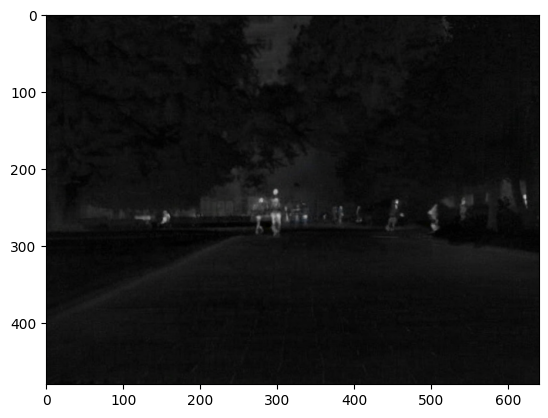

In [10]:
import matplotlib.pyplot as plt

# test encoded
npy = np.load('/Data3/cao/ZiHanCao/exps/panformer/task_datasets/VIF-MSRS/Degraded/train/00005N.encoded_ir_degraded.npy')
print(npy.shape)
encoded = torch.from_numpy(npy).half().cuda()[None]
print(encoded.shape)

with torch.no_grad():
    decoded = decoder(encoded)
    print(decoded.shape)
    decoded = decoded.float()

decoded = (decoded + 1) / 2

plt.imshow(decoded.cpu().numpy()[0].transpose((1, 2, 0)))
plt.show()

In [5]:
import matplotlib.pyplot as plt

# raw image and reconstructed image

decoded = (decoded + 1) / 2
decoded = np.clip(decoded, 0, 1)

plt.figure(figsize=(10, 5), dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(decoded)
plt.title('Reconstructed Image')
plt.axis('off')

# psnr compute
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

ssim_index = ssim(img, decoded, channel_axis=-1, data_range=1.)
psnr_index = psnr(img, decoded)

print(f'SSIM: {ssim_index:.4f}, PSNR: {psnr_index:.4f}')

# plt.savefig('reconstructed_image.png')
plt.show()
    

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [28]:
from pathlib import Path
import shutil
from tqdm import tqdm

data_vi_path = Path('/Data3/cao/ZiHanCao/datasets/VIF-MSRS/test/vi')
fused_path = Path('/Data3/cao/ZiHanCao/exps/panformer/visualized_img/RWKVFusion_v12_RWKVFusion/msrs_11_30_all')
fused_cp_dir = Path('/Data3/cao/ZiHanCao/datasets/VIF-MSRS/test/gt')

for data_path in tqdm(data_vi_path.glob('*')):
    data_name = data_path.name
    fused_data_path = fused_path / data_name
    if not fused_data_path.exists():
        print(f'{fused_data_path} does not exist')
        continue
    
    shutil.copy(fused_data_path, fused_cp_dir)

361it [00:01, 360.31it/s]
